# Lesson 1: Connecting unit operations and generating flow

Chromatographic systems always require some kind of convective flow through the column. 

In this lesson, we will:
- Create and connect our first systems of unit operations.
- Define inlet profiles using piecewise cubic polynomials.
- Run CADET and analyze the results.

## Example 1: Flow from INLET to OUTLET

In a first example, we will look at a simple system with just two unit operations, an [INLET](https://cadet.github.io/master/modelling/unit_operations/inlet), and an [OUTLET](https://cadet.github.io/master/modelling/unit_operations/outlet).

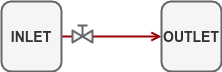

We will introduce flow from the `INLET` to the `OUTLET` with a constant flow rate of $Q = 1~mL \cdot s^{-1}$. 
In the first section, the concentration is $1.0~mM$, and after $1~min$, it is changed to $0.0~mM$.

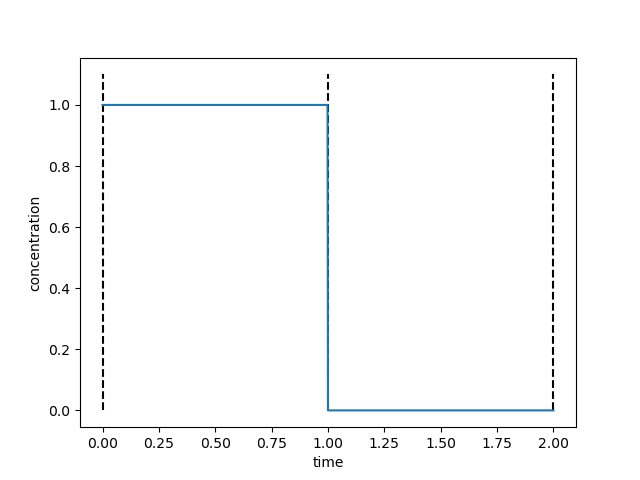

<div class="alert alert-info">

**Note:** 
    
Generally, CADET can be used with any consistent system of units.
However, we strongly recommend converting everything to the SI system.
    
</div>


## 0. Load CADETSettings

This imports all the standard libraries and provides some helper functions.

In [1]:
%run ../utils.ipynb

## 1. Setting up the model

Before we start with specifying the system, we define some local auxiliary variables.
Note that we have to convert all units to SI units.

In [2]:
n_comp = 1 
t_cycle = 60    # 1 min = 60 s
Q = 1e-6        # 1 mL/s = 1e-6 m^3/s

Then, we load a model template from the [utility module](../utils.ipynb#Templates-for-CADET-simulations).
The template sets defaults for numerical parameters and configures which parts of the solution should be saved.

<div class="alert alert-info">

**Note:** 

These utility functions are not part of the official `CADET` package but were created to reduce the amount of typing required in these tutorials.

</div>

To use it, we have to specify the number of unit operations.

In [3]:
model = get_cadet_template(n_units=2)

### Inlet
In CADET, the `INLET` pseudo unit operation serves as source for the system and is used to create arbitary concentration profiles as boundary conditions (see also [here](https://cadet.github.io/master/modelling/unit_operations/inlet)).
We define an `INLET` as the first unit operation by adding the field `unit_000` in the `/input/model/` group.
The concentration profile is described using a third degree piecewise polynomial for each component. 
Later, we will define the pieces, when we look at sections.

In [4]:
model.root.input.model.unit_000.unit_type = 'INLET'
model.root.input.model.unit_000.ncomp = n_comp
model.root.input.model.unit_000.inlet_type = 'PIECEWISE_CUBIC_POLY'

### Outlet
The `OUTLET` is another psuedo unit operation that serves as sink for the system (see also [here](https://cadet.github.io/master/modelling/unit_operations/outlet)).

In [5]:
model.root.input.model.unit_001.unit_type = 'OUTLET'
model.root.input.model.unit_001.ncomp = 1

## 2. Setting up Sections and Connections

[Sections](https://cadet.github.io/master/simulation/index.html#time-sections-and-transitions) are used to specify changes of parameter values during the simulation.
A section typically corresponds to an operating step (load, wash, elute etc.), but can also be used to indicate changes in connectivity, or even discontinuities of [model parameters](https://cadet.github.io/master/interface/introduction.html#section-dependent-model-parameters). 

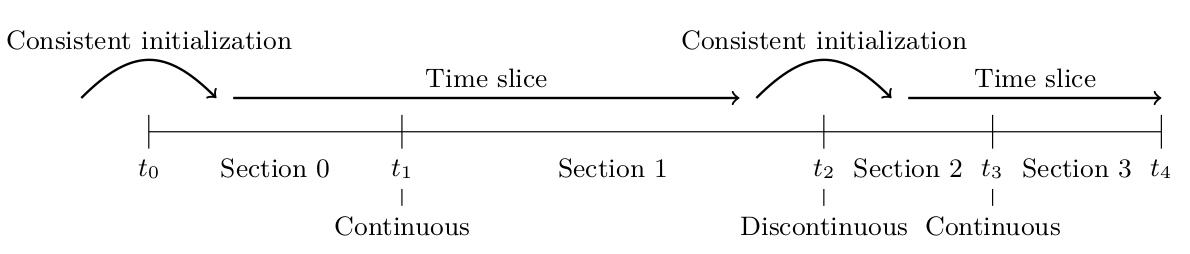
In the `/input/solver/sections/` branch, `nsec` denotes the number of sections.
The start and end times of a section are given in the `section_times` vector.
It should always start at `0` and contains `nsec + 1` values, i.e., the `i`th section goes from `section_times[i]` to `section_times[i+1]`.

The `section_continuity` indicates whether a transition from one section to the next is continuous in both the inlet and the parameters.
It has `nsec - 1` number of values, since there is one less transition than there are sections.
The continuity is used in CADET's time integrator which needs to decide whether to restart on entering a new section.
If the transition is continuous, the time integrator can try to step over the transition without restarting, thus saving some computation time (since the restart is costly).
If you are unsure about the continuity, just leave it at `0`.

For our example, we will define two sections by adding the fields `sec_000`, and `sec_001` to the inlet unit (`unit_000`).
For modelling the concentration step, we set `const_coeff` to `[0.0]`, and `[1.0]`, respectively and all other cofficients to `[0.0]`.
Note that for more components, a vector of coefficients needs to be specified.

In [6]:
model.root.input.solver.sections.nsec = 2
model.root.input.solver.sections.section_times = [0.0, t_cycle/2, t_cycle]   # s
model.root.input.solver.sections.section_continuity = [0]

As mentioned earlier, we now define the `INLET` profile using a third degree piecewise polynomial.
On each section $[ t_i,  t_{i+1} ]$ a cubic polynomial $p_i$ is defined:
$$
p_i( t ) = d * (t - t_i)^3 + c * (t - t_i)^2 + b * (t - t_i) + a,
$$
where the coefficients of the polynomial are `const_coeff` (a), `lin_coeff` (b), `quad_coeff` (c), and `cube_coeff` (d).
Note that the constant coefficient `const_coeff` determines the starting concentration on each section. 
The stopping concentration is given by $p_i( t_{i+1} )$ or $p_{i+1}( t_{i+1} )$ in case of a continuous profile.


In [7]:
model.root.input.model.unit_000.sec_000.const_coeff = [1.0,] # mM
model.root.input.model.unit_000.sec_000.lin_coeff = [0.0,]
model.root.input.model.unit_000.sec_000.quad_coeff = [0.0,]
model.root.input.model.unit_000.sec_000.cube_coeff = [0.0,]

model.root.input.model.unit_000.sec_001.const_coeff = [0.0,] # mM
model.root.input.model.unit_000.sec_001.lin_coeff = [0.0,]
model.root.input.model.unit_000.sec_001.quad_coeff = [0.0,]
model.root.input.model.unit_000.sec_001.cube_coeff = [0.0,]

In order to specify the [connectivity of the network](https://cadet.github.io/master/modelling/networks.html), we have to provide a matrix with list of connections in row-major storage.
Moreover, we have to specify the section in which the specified connectivity should be applied.

The columns are (see also [here](https://cadet.github.io/master/interface/system.html#group-input-model-connections)): 

    [UnitOpID from, UnitOpID to, Component from, Component to, volumetric flow rate]
    
Usually, `Component from` and `Component to` can be set to `-1`, which will connect all components from the origin and destination unit operations.
Since CADET version 4.1, the flow rates can also be defined with piecewise cubic polynomials. Also, for the 2D General rate model inlet ports need to be speciefied. For more information on the parameters, 

In this case, we connect all components from `unit_000` to `unit_001`. 


<div class="alert alert-info">

**Note:** 

If `nswitches` is smaller than `nsec`, CADET will cycle through the connections. In this case, it will always consider the same connectivity. 
    
</div>

In [8]:
model.root.input.model.connections.nswitches = 1
model.root.input.model.connections.switch_000.section = 0
model.root.input.model.connections.switch_000.connections = [
    0, 1, -1, -1, Q, # unit_000, unit_001, all components, all components, Q/ m^3/s
]  

## 3. Setting up the simulator and running the simulation

Most of the parameters for the simulator are set by default in the utils script.
For more information, see also [here](https://cadet.github.io/master/simulation/index.html).

Finally, we have to set the time points at which we want to evaluate the solution.
Note that the end time must not exceed the last section time specified in the model.
If the time points are not set explicitly, the time integrator outputs the solution at arbitrary time points between `0` and `section_times[-1]`.

In [9]:
model.root.input.solver.user_solution_times = np.linspace(0, t_cycle, 1001)

Now, we can call the run function:

In [10]:
run_simulation(model)

Simulation completed successfully


## 4. Plotting the results
The data is stored in the `/output/` branch of the Cadet object.
For more information, check the corresponding chapter in the [manual](https://cadet.github.io/master/interface/output_group.html).

We then create a figure, plotting the solution at the input (also called inlet) of the `OUTLET` unit operation over the simulation time.

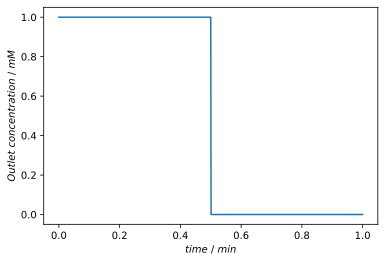

In [11]:
plt.figure()

time = model.root.output.solution.solution_times
c = model.root.output.solution.unit_001.solution_inlet
plt.plot(time/60, c)
plt.xlabel('$time~/~min$')
plt.ylabel('$Outlet~concentration~/~mM$')
plt.show()